In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn_pandas import DataFrameMapper

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDRegressor

from sklearn.externals import joblib

import warnings
warnings.filterwarnings("ignore")

# Assignment 2 - Lending Club Predictive Model
## Josh Broomberg

This assigment is broken down into two parts. First, **data preparation**. Second, **modelling**. Part 1, covers the techniques used for data cleaning, feature selection, and feature prepation. Part 2, covers the methodology and results for the predictive modelling. 



## Part 1: Data Preparation

Preparing the raw data involved 4 discrete steps. First, choosing which data to use. Second, preparing the two sets of data, covering accepted and rejected loans, for merge. Third, data cleaning and preparation, which involved handling missing data, cleaning text columns, and assigning categories. And, finally, preparing features for modelling - encoding and scaling the features. 

### 1. Choosing Data

** Selecting a Time Range **

The very first step in the process of data preparation was choosing which data to use, both in terms of the range of historical data to incorporate and which features to select from particular range. We selected Q3 2017, the most recent subset of data, as a starting point. This made sense for two reasons. First, that this range alone had over 1 million rows - an ample number of examples to work with. But, more importantly, we hypothesize that loan decisions will be correlated with time such that using the most recent data should give the best predictions when this model is production. 

The thinking behind the time correlation is two-fold. First, because macro-economic conditions affect the amount of free capital (savings) which can be loaned. These conditions change on a year-to-year basis depending on interest rate, economic growth etc. Second, because smart lenders should incorporate prior loan performence/information into new loan decisions. This means trying to predict loan decision behaviour across a large time series would probably involve modelling slightly-different, backward-dependent decision functions. If this is the case, then the most recent data has incoporated the learning of the past, so it is best to use only the recent data. If we are wrong, and there is no correlation, then not much is lost in using on Q3 2017. More data could always be used for training later. 

** Selecting Features **

As a rule, selecting+engineering features involves maximizing the amount of information available to the model subject to any constraints. In this case, the first constraint was clear: in order to build a model which incorported both accepted and rejected data, the features used had to be present across both datasets. This essentially made the rejected data the guide for feature selection due to the much smaller number of features in the reject data. It's worth noting that this constraint didn't actually translate into substantial information loss. The majority of features in the accepted data concerned loan performence post-acceptance. Any information on loan approval coming from these features would indicate 'learning' on behalf of lenders, and we hoped that this learning would be largely incorporated into the accept/reject decisions in 2017 as explained above. So, the smaller number of features in the reject data was actually a useful tool to process an otherwise overwhelmingly-large accepted feature set. 

The features used where as below:

| Feature Name | Name in Rejected Data | Name in Accepted Data |
|--------------|-----------------------|-----------------------|
| loan_amnt    | Amount Requested      |  loan_amnt            |
| funded_amnt  |            0          |  funded_amnt          |
| title        | Loan Title            |  purpose              |
| dti          | Debt-To-Income Ratio  |  dti                  |
| zip          | Zip Code              |zip_code               |
| state        | State                 |   addr_state          |
|  emp_len     | Employment Length     | emp_length            |
| approved     | FALSE                 |      True             |
|  grade       | Risk_Score            |     sub_grade         |

1. **Loan_amnt** represents the amount requested by the borrower. This is was central to the first modelling approach.
2. **Funded_amount** represents the amount granted by the Lending Club. This was set to 0 for the rejected borrowers. This feature was central to the other modelling approach. 
3. **Title** represents the high level purpose/reason for the loan. In the reject data this was free form text provided by the applicant. In the accepted data, this was pre-clean and always took on one of a few predefined category values. 
4. **Dti** represents the borrowers debt to incoming ratio. This was a text column with a '%' sign in the reject data and a numerical column in the accepted data.
5. **Zip** and **state** represent the location of the borrower. These were in the same format accross both data sets. 
6. **Emp_len** is the length of employment. This was categorical for both data sets, with the possible of n/a (presumably for unemployed individuals or those who didn't declare employment). 
7. **Approved** was a synthetic variable added by us to mark which data set the observation came from. 
8. **Grade** represents a borrowers creditworthiness. In the accepted data, we used sub_grade which had an alphanumeric ranking for tranches A1 - G5. Research showed that these tranches were assigned based on the borrowers credit score - which was represented as Risk_Score in the reject data. More on this later. 

The only two columns from the reject data which were not used were **application date** and **policy code**.
- **Policy code** was excluded because research (found [here](https://www.lendacademy.com/policy-code-2-loans-lending-club/)) showed that it was assigned to particularly high-risk lenders based on credit score. Thus, we excluded it because the information contained was tightly correlated to **grade**. This decision was only made after data cleaning had be performed, so the column is still present in the code below (although not in the models). 


- **Application date** was excluded because there was no clear counter-part in the accepted data (only the loan disbursement date was recorded) and we didn't believe the precise date would convey meaningful information (that would generalize into the future).

### 2. Preparing Data for Merge

Our goal was to do the majority of cleaning on the merged data set to avoid duplicated effort. So only minimal work strictly required by only one subset of the data was performed. This meant transforming two columns in the reject data to match the form on the accepted table/improve usability for the model.

- The percentage sign was removed from the reject dti column and the data cast to numeric type.
- The **Risk Score** was split into 35 bins corresponding to the 35 **sub_grades** on the accept table. The choice to preserve the bins was based on a hypothesis about relevant information. It is unlikely that variation in the 15 FICO point range in each bin would provide much information. Thus, it was sufficient to retain on the 'grade' and not the score itself.

After these modifications, the two data sets were merged.

#### Reading in the Data

In [2]:
# The last 3 rows are empty
accepted_data = pd.read_csv("./CS156/LoanStats_2017Q3.csv", header=0, skipfooter=3, engine="python")
accepted_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,7000,7000,7000,36 months,7.97%,219.26,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,32000,32000,32000,36 months,11.99%,1062.71,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,16000,16000,16000,36 months,7.97%,501.17,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,40000,40000,40000,60 months,15.05%,952.65,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,33000,33000,33000,36 months,7.21%,1022.12,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
rejected_data = pd.read_csv("./CS156/RejectStats_2017Q3.csv", header=0, engine="python")
rejected_data.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,3000,7/1/17,medical,NaN,0.24%,373xx,TN,5 years,0
1,15000,7/1/17,car,NaN,0.71%,945xx,CA,NaN,0
2,2000,7/1/17,debt_consolidation,NaN,40.90%,532xx,WI,5 years,0
3,5000,7/1/17,Moving and relocation,537.0,5.84%,606xx,IL,< 1 year,0
4,20000,7/1/17,debt_consolidation,NaN,45.59%,917xx,CA,< 1 year,0


#### Merging the Data Sets

**Accepted data**

In [4]:
# Omit all columns not present in the reject data.
# Add colum for approved status (always false)

# Purpose is a cleaner version of title, broken into categories.
cleaned_accept_data = accepted_data.loc[:, ["loan_amnt", 'funded_amnt', "purpose", "dti", "zip_code", "addr_state", "emp_length", "approved", "policy_code", "sub_grade"]]

# Add values to new columns
cleaned_accept_data["approved"] = True

# Set shared column names
cleaned_accept_data.columns = ['loan_amnt', 'funded_amnt','title','dti','zip','state','emp_len','approved', 'lc_code', 'grade']

cleaned_accept_data.head()

,loan_amnt,funded_amnt,title,dti,zip,state,emp_len,approved,lc_code,grade
0,7000,7000,debt_consolidation,12.27,604xx,IL,10+ years,True,1,A5
1,32000,32000,credit_card,12.35,080xx,NJ,10+ years,True,1,B5
2,16000,16000,debt_consolidation,15.94,223xx,VA,5 years,True,1,A5
3,40000,40000,debt_consolidation,31.11,778xx,TX,9 years,True,1,C4
4,33000,33000,debt_consolidation,19.06,750xx,TX,< 1 year,True,1,A3


**Rejected data**

In [12]:
# Omit Risk Score and Application Date because they are present in the accept set.
# Add colum for funded amount (always 0) and approved status (always false)
cleaned_reject_data = rejected_data.loc[:, ["Amount Requested", 'funded_amnt', "Loan Title", "Debt-To-Income Ratio", "Zip Code", "State", "Employment Length", "approved", "Policy Code", "Risk_Score"]]

# Add values to new columns
cleaned_reject_data["funded_amnt"] = 0
cleaned_reject_data["approved"] = False

# Set shared column names
cleaned_reject_data.columns = ['loan_amnt', 'funded_amnt','title','dti','zip','state','emp_len','approved', 'lc_code', 'grade']

# Clean the Debt-to-Income column by removing the %:
cleaned_reject_data["dti"] = cleaned_reject_data["dti"].replace({'%':''}, regex = True)

# Make the risk score match the grades in the accepted set
# by spliting the continuous variable into buckets which match 
# the division in the accepted data.
custom_bucket_array = np.linspace(300, 850, 36)
labels = ["{}{}".format(chr(letter), number) for letter in range(65, 72) for number in range(1, 6)]
cleaned_reject_data['grade'] = pd.cut(cleaned_reject_data['grade'], bins=custom_bucket_array, labels=labels)

cleaned_reject_data.head()

,loan_amnt,funded_amnt,title,dti,zip,state,emp_len,approved,lc_code,grade
0,3000,0,medical,0.24,373xx,TN,5 years,False,0,NaN
1,15000,0,car,0.71,945xx,CA,NaN,False,0,NaN
2,2000,0,debt_consolidation,40.90,532xx,WI,5 years,False,0,NaN
3,5000,0,Moving and relocation,5.84,606xx,IL,< 1 year,False,0,D1
4,20000,0,debt_consolidation,45.59,917xx,CA,< 1 year,False,0,NaN


In [13]:
loan_data = pd.concat([cleaned_accept_data, cleaned_reject_data])

### 3. Data Cleaning and Preparation

The next step was to clean the data in the merged set. The primarily concerned handling missing information as well as some other small actions.

** Handling Missing Data **

A scan for missing fields is displayed below. This was used to guide the cleaning process. The following actions were taken for each column:

- **Grade** had 615526 missing values, around 53% of the total data. This meant any imputation risked materially skewing the data for what would likely be an important feature. So, we decided to drop all rows that had a missing grade. It's worth noting that we ran cross-validation on the data set with missing grade data filled in as the middle bucket (under the working assumption that this was 'neutral' information). This value, D3, became the most important feature in our model (after one-hot encoding) and the approximated performence declined. This was a good case of CV preventing poor data cleaning.


- **Zip** had one missing value, so this row was dropped without much further thought. 


- **Title** had 412 missing values. These were set to be the category 'other' under the assumption that there was no meaningful difference between the information contained by a blank field vs an other field. Both are essentially the choice not to reveal the loan's purpose. This would be worth validating if there were more observations with missing title, indicating a potentially menaingful pattern. In this case, there were too few for this to be relevant.


- **DTI** had 412 missing values and required a little more leg work to repair. We thought, a priori, that this feature was important and worth preserving. Exploration of the distribution using a histogram revealed extreme outliers, so we decided to impute the value using the median of the column as the more robust statistic. It is worth nothing that DTI also had a number of -1 values. We assumed that the -1 represented a person with no income, such that their DTI would be inf. Under this assumption, when we later scaled the feature, we replace the -inf that resulted from $\log{(1+(-1))}$ with the max of the scaled feature.


- **Employment length** had 71882 missing values (around 6% of the data set). We set these to the category 'n/a' under the assumption that missing information on employment should be treated as no employment. It is highly unlikely that someone applying for a loan, who is employed, would choose not to reveal this employment if it did exist. We felt fairly comfortable with this equivocation.

** Title Text Cleanup **

The title (purpose) text from the reject data appeared to be broader than the categories in the accepted data. We used regex to apply a simple key word heuristic in order to narrow down the categories. For example any reason that contained the word 'car' was classified as a car loan. The regex rules are visible in the code below. The final categories were:

- business
- moving
- credit card
- car
- medical
- green loan
- other

** Categorization **

Finally, the fields below were cast as pandas categorical variables in preparation for encoding. These were all fairly clearly categorical in nature. Two decisions are worth mentioning. First, we chose to set employment length as an unordered categorical rather than as an ordinal category. We thought the relationship between employment length and reliability/approval could be non-linear so we thought that the model should be given the flexibility to treat each employment period as a distinct feature rather than looking at an ordinal range. Similar logic applied to the grade feature. Second, we choose to leave state/zip in the raw form rather than doing any engineering to group zip codes together (perhaps by wealth?). This was largely due to time constraints. It is also worth noting that there is an obvious overlap in information between zip/state. The model we used was robust to correlated variables, so we decided to leave both in. More on this later.

The following features were made into categories:

- emp_len
- title
- zip
- state
- grade

The code for cleaning the data is below:

#### Clean Combined data

In [18]:
# Explore for NAs
for column in loan_data.columns:
    blanks = loan_data[column].isnull().sum()
    print("{}: {}, {}%".format(column, blanks, 100*np.round(blanks/float(len(loan_data)), 6)))

loan_amnt: 0, 0.0%
funded_amnt: 0, 0.0%
title: 412, 0.0352%
dti: 184, 0.0157%
zip: 1, 9.999999999999999e-05%
state: 0, 0.0%
emp_len: 71882, 6.1371%
approved: 0, 0.0%
lc_code: 0, 0.0%
grade: 615526, 52.55180000000001%


In [19]:
loan_data.dtypes

loan_amnt       int64
funded_amnt     int64
title          object
dti            object
zip            object
state          object
emp_len        object
approved         bool
lc_code         int64
grade          object
dtype: object

** Remove NAs **

In [20]:
### Grade

# Strategy 1: Replace all grades with the median. 
# Rejected because this ended up becoming the most important feature
# and we have enough data without this imputation.
# Replace all missing grades with the middle bucket.

# loan_data.grade.fillna("C3", inplace=True)

# Strategy 2: Drop all rows with missing grade.
loan_data = loan_data[pd.notnull(loan_data['grade'])]
print("NA in Grade: {}".format(loan_data["grade"].isnull().sum()))

NA in Grade: 0


In [21]:
### ZIP

# For the single missing zip, drop the row. 
loan_data = loan_data[pd.notnull(loan_data['zip'])]
print("NA in Zip: {}".format(loan_data["zip"].isnull().sum()))

NA in Zip: 0


In [22]:
### Emp_len

# Treat NAs here as a declaration of "not applicable" by the applicant.
loan_data.emp_len.fillna("n/a", inplace=True)
print("NA in emp_len: {}".format(loan_data["emp_len"].isnull().sum()))

NA in emp_len: 0


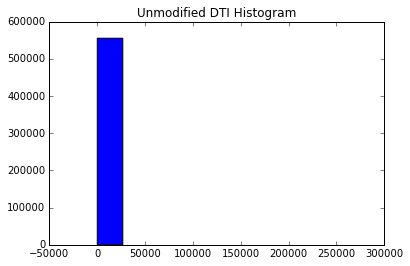

DTI Stats
median 21.43
max 266775.0
mean 87.8605798421


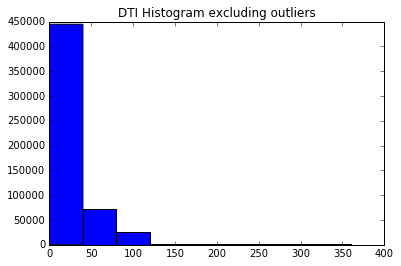

In [23]:
### DTI

stripped_dti = pd.to_numeric(pd.Series(loan_data.dti.dropna())).values

# For the DTI, an initial plot shows a weird histogram. 
plt.hist(stripped_dti, bins=10)
plt.title("Unmodified DTI Histogram")
plt.show()

# Exploring the stats shows clear skew:
print("DTI Stats")
print("median", np.median(stripped_dti))
print("max", np.max(stripped_dti))
print("mean", np.mean(stripped_dti))

# This is revealed in a moderated histogram.
plt.hist(pd.to_numeric(pd.Series(loan_data.dti.dropna())).values, bins=10, range=(0, 400))
plt.title("DTI Histogram excluding outliers")
plt.show()

In [24]:
# Replace the missing DTI values with the median.
# as this is more robust to outliers than the mean.
loan_data.dti.fillna(np.median(stripped_dti), inplace=True)
loan_data["dti"] = pd.to_numeric(loan_data["dti"])

print("NA in DTI: {}".format(loan_data["dti"].isnull().sum()))

NA in DTI: 0


In [25]:
### TITLE

print("Titles prior to clean")
print(loan_data.title.unique())

Titles prior to clean
['debt_consolidation' 'credit_card' 'home_improvement' 'car' 'other'
 'major_purchase' 'house' 'medical' 'moving' 'small_business' 'vacation'
 'renewable_energy' 'Moving and relocation' 'Home improvement'
 'Debt consolidation' 'Credit card refinancing' 'Car financing'
 'Home buying' 'Business' 'Vacation' 'Other' 'Major purchase'
 'Medical expenses' 'Green loan']


In [26]:
replacements = {
      r"_": " ",
      r".*(business).*": "business",
      r".*(moving).*": "moving",
      r"(credit card).*": "credit card",
      r"^(car).*": "car",
      r"(medical).*": "medical",
      r"renewable energy": "green loan"
    
}
loan_data.title = loan_data.title.str.lower()
loan_data.title.replace(replacements, regex=True, inplace=True)
loan_data.title.fillna("other", inplace = True)


print(loan_data.title.unique())
print("NA in Title: {}".format(loan_data["title"].isnull().sum()))

['debt consolidation' 'credit card' 'home improvement' 'car' 'other'
 'major purchase' 'house' 'medical' 'moving' 'business' 'vacation'
 'green loan' 'home buying']
NA in Title: 0


In [27]:
# Explore for NAs
for column in loan_data.columns:
    print("{}: {}".format(column, loan_data[column].isnull().sum()))

loan_amnt: 0
funded_amnt: 0
title: 0
dti: 0
zip: 0
state: 0
emp_len: 0
approved: 0
lc_code: 0
grade: 0


In [28]:
loan_data.dtypes

loan_amnt        int64
funded_amnt      int64
title           object
dti            float64
zip             object
state           object
emp_len         object
approved          bool
lc_code          int64
grade           object
dtype: object

** Assign Categories to Categorical Data **

In [29]:
# DEPRECATED: Category assignment
# loan_data["emp_len"] = pd.Series(
#     pd.Categorical(
#         loan_data.emp_len,
#         categories=['n/a', '< 1 year', '1 year', '2 years', '3 years','4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'], ordered=True))
# emp_categories = ['n/a', '< 1 year', '1 year', '2 years', '3 years','4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

In [18]:
# Assigned categories to emp_len, title, zip, and state
fields = ["emp_len", "title", "zip", "state", "grade"]
for field in fields:
    loan_data[field] = loan_data[field].astype('category')

# Test
loan_data["emp_len"].value_counts()

### 4. Encoding and Scaling

At this stage, all the features have been cleaned. The final step before modelling is to encode and scale. This was primarly done using the data_frame mapper which bridges pandas dataframes with scikit feature encoders. This automated much of the process.

- ** Encoding Categorical Features: ** Zip, Employment Length, Grade, State, and Title were encoded using the OneHotEncoder. This produces n features for the n unique values in each category. The assumption being that there is no ordinality in the category. The use of this encoding was justified in section 3 above.


- ** Scaling Continuous Features: ** more care was taken with DTI, Loan Amount, and Funded Amount. Examination of the plots revealed positively skewed distributions across the board, with a particularly bad skew on DTI. Additionally, it was clear from the plots that there were outliers present in the DTI feature and that the reject data was substantially affecting the distribution of funded amount. Two actions were taken - first, each of the features was logged in order to bring exponential patterns into the linear domain. Second, each of the three was scaled using the scikit RobustScaler. This scaler removes the median from the value and divides by the inter-quartile range (rather than removing the mean and dividing by the standard deviation) which makes it more robust to outliers. The result of these transformations, as seen in the post-processing plots, was that all three features had a dsitrbution which appeared approximate-normal. The key observation here is that the resultant distributions encode roughly the same information as the original values but the approximate-normal shape means they better conforms to the assumptions underlying the model training process. IE, that statistics like MSE are an accurate description of the models fit.


- ** Spotting Imbalances in Categorical Features **: the normalization/scaling stage was a natural place to explore the distribution of all features. We observe when looking at the breakdown of the Approved and Grade features that both of these features also have a fairly pronounced skew toward one/some categories. Action was taken to correct the skew on approved during the modelling process. No action was taken to address the imbalance in grade distribution. Further work would aim to address this to see if it generated improved performence.

loan_amnt
Mean: 12914.44373988977
Median: 10000.0
Max: 87750

funded_amnt
Mean: 3223.0402573823794
Median: 0.0
Max: 40000

dti
Mean: 87.83858569246266
Median: 21.43
Max: 266775.0



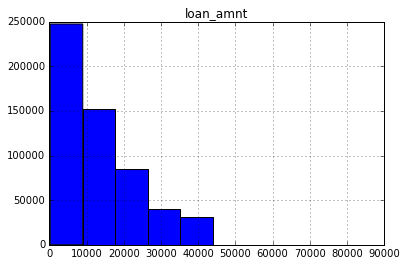

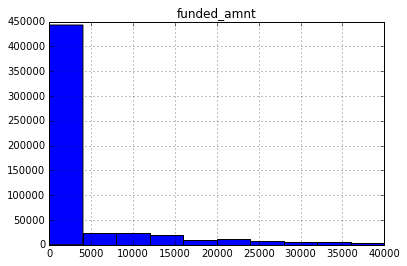

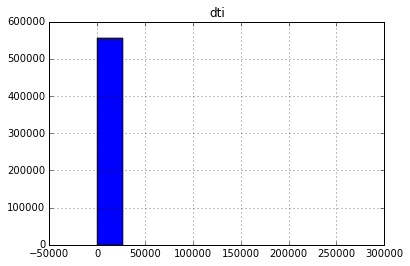

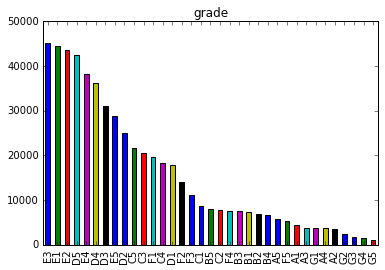

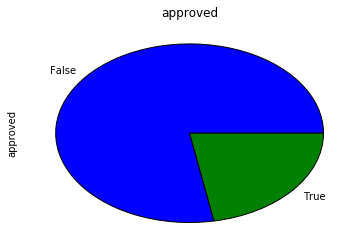

In [43]:
# First, naive plot
for column in ['loan_amnt', 'funded_amnt', 'dti']:
    loan_data.hist(column=column)
    print(column)
    print("Mean: {}".format(np.mean(loan_data[column])))
    print("Median: {}".format(np.median(loan_data[column])))
    print("Max: {}".format(np.max(loan_data[column])))
    print()
    
plt.show()  

loan_data['grade'].value_counts().plot(kind='bar', title="grade")
plt.show()  

loan_data['approved'].value_counts().plot(kind='pie', title="approved")
plt.show()   

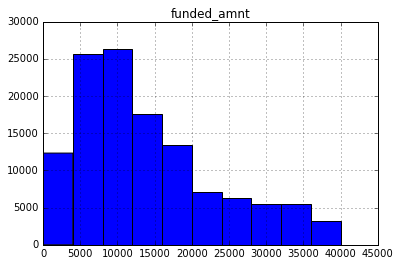

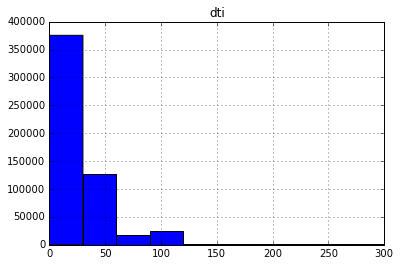

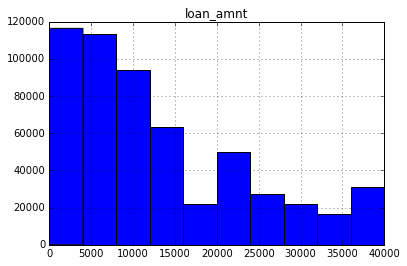

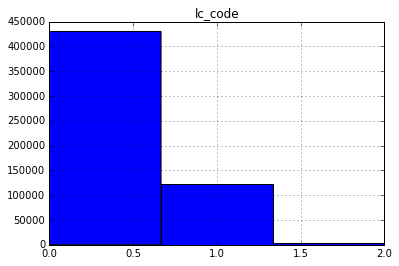

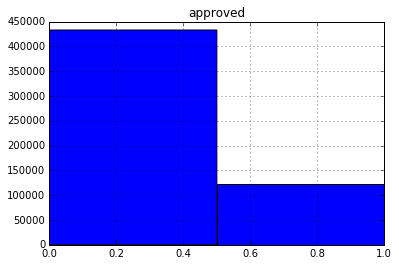

In [20]:
# Make some quick manual adjusted to represent what
# the removal of the outliers. 
plots = {
    "loan_amnt": {"range": (0, 40000)}, # outliers removed
    "funded_amnt": {"range": (1, 40000)}, # zeros removed
    "approved": {"bins": 2},
    "lc_code": {"bins": 3},
    "dti": {"range": (0, 300)}} # outliers removed

for column, kwargs in plots.items():
    loan_data.hist(column=column, **kwargs)

plt.show()

** Begin Processing**

In [21]:
# Convert categories to integers so
# that they can be processed by scikit.

fields = ["emp_len", "grade", "title", "zip", "state"]
for field in fields:
    print(field + " processed")
    loan_data[field] = loan_data[field].cat.codes

emp_len processed
grade processed
title processed
zip processed
state processed


In [22]:
# Scale the numercial values

loan_data.loan_amnt = loan_data.loan_amnt.apply(np.log1p)
loan_data.funded_amnt = loan_data.funded_amnt.apply(np.log1p)
loan_data.dti = loan_data.dti.apply(np.log1p)

# Assume that the -1 in the DTI column represents 
# a person with no income, such that their DTI would be inf. 
# Under this assumption, replace the -inf result of log(1+-1)
# with the max of the dist.
loan_data.dti = loan_data.dti.replace(-np.inf, max(loan_data.dti)+1)

In [23]:
# Apply the correct encoding/scaling to 
# each of the features.
encode_data = DataFrameMapper([
        (['zip'], [preprocessing.OneHotEncoder()]),
        (['emp_len'], [preprocessing.OneHotEncoder()]),
        (['grade'], [preprocessing.OneHotEncoder()]),
        (['title'], [preprocessing.OneHotEncoder()]),
        (['state'], [preprocessing.OneHotEncoder()]),
        (['dti'], [preprocessing.RobustScaler()]),
        (['loan_amnt'], [preprocessing.RobustScaler()]),
        (['funded_amnt'], [preprocessing.RobustScaler()]),
        ('approved', None),
        
    
    # Retired Features
    # lc_code, research revealed policy code is a proxy for risk score
    # and is only assigned to accepted loans.
    #         (['lc_code'], [preprocessing.OneHotEncoder()]),
    ], df_out= True)

processed_loan_data = encode_data.fit_transform(loan_data)

write = False
if write:
    # Output the processed data to file to avoid
    # the need to rerun the processing while working
    # on the model in a new session.
    processed_loan_data.to_csv("prepared_loan_data.csv")

In [24]:
processed_loan_data.head()

,zip_0,zip_1,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,zip_9,...,state_45,state_46,state_47,state_48,state_49,state_50,dti,loan_amnt,funded_amnt,approved
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.492785,-0.257284,8.853808,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.487147,0.839077,10.373522,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-0.263744,0.339046,9.680406,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.336118,1.000054,10.596660,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.105170,0.861276,10.404293,1.0


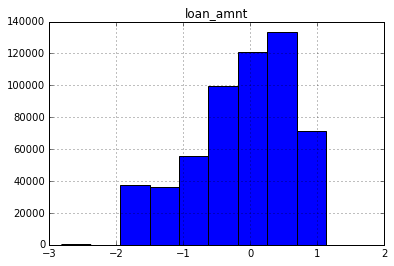

In [25]:
processed_loan_data.hist(column="loan_amnt")
plt.show()

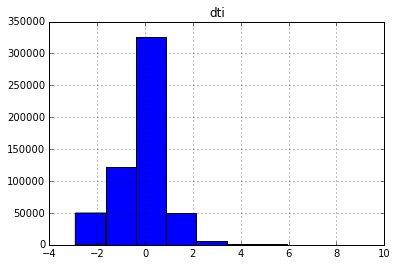

In [26]:
processed_loan_data.hist(column="dti")
plt.show()

## Part 2: Modelling

Onto the modelling! This was an interesting problem, because it lended itself to both regression and classicifaction (and potentially a combination). Classification arises if we phrase the question as: "How high can the loan amount be before yielding a rejection". Regression arises if we phrase this problem as "what does the average recipient with features X receive in terms of funding" (such that it's probable that requesting more than this amount would yield a rejection). Both approaches appear viable, and both were implemented. The detail is below. However, before getting to this, we discuss our model choice.

Both the classification and regression were built using a Random Forest (although a slightly different flavour for each model type). This choice was made because Random Forests have a number of properties which were partcularly well suited to this problem:

- First, the model fitting procedure produces what's called an Out-of-Bag (OOB) error which approximates the test error. This is possible because each tree is built using a bootstrapped sample which exludes an average of 1/3 of the observations per tree. Each observation is then classified/regressed using the trees which did not see that observation during training to create the OOB. This is essentially a built-in cross-validation process, which allows for the evaluation of small changes without having to explcitly run CV. 


- Second, the model benefits from a large number of features wit. This stems from the fact that a random forest creates variance amongst the individual trees by limiting which features can be split on at each decision node. This means different features are given a change to influence predictions even if they would normally be consistently dominated in a linear regression setting. The result is that Random Forests can extract a lot of information from features even if they are  numerous and correlated with each other. 

- Third, Random Forests protect against overfitting (to a certain extent). Random Forests use relatively small decision trees in large numbers. In this setting, each tree has relatively high bias (because of the feature limiting described above) but averaging the prediction from the trees nullifies this bias and produces a prediction with very low variance. The result is that the model is not particularly sensitive to the noise in the training data. If the hyperparamaters of the model, discussed shortly, are kept within normal range. It is hard to overfit.

** Random Forest Parameters **

Our work foused on two of the +-10 hyperparameters available when using a Random Forest. Namely, **max tree depth** and **max number of features**. The max tree depth controls how many splits there are on each tree effectively controlling the variance of each tree. The more splits are made, the closer the dependency between the tree shape and the the observations used. The max number of features controls the tree bias. The fewer features are used, the more systematic error there will be in the trees predictions. The key to a random forest is that this systematic bias is zero-mean and should average out when many trees are used together.

There are other hyperparameters which affect the fitting process. Many like the minimum number of observations in a leaf, or the minimum purity increase also affect the variance of the trees grown by changing when/how many splits occur. The scoring function is also important, but this is specific to each of the classifier/regressor.

** Sample weighting **

One final note is that sample weighting was an important components of the model fitting process in both model types. In the classifier, the balanced_subsample option was used to assign weights to samples based on the inverse proportion of a class *within the bootstrap sample for each tree*. The regression was run with and without weighting to determine which was the best for performence. 


With these shared premises estblished, we move onto the classification approach. 

### Classification

** Methodology **

The key idea here is to build a model which can predict whether or not a loan will be rejected. Once this is done, we can accept some feature set X which will include the amount of funds requested (loan amount) and other features specific to the person. Then, to create a prediction of maximum amount fundable, we would keep all features except loan amount constant and increase loan amount until the loan classification changed from accepted to rejected (at some defined probability threshold). It's worth noting that the loan status could flip between accepted and rejected more than once if the fitted function is non-linear in amount (which is likely). 

In order to pursue this idea, a Random Forest classifier was fit to the class-weighted data. No particular emphasis was placed on avoiding false-positives or negatives because it is not clear that either of these results is more damaging than the other. Applying for a loan with an amount that is too high (false positive) has a large administrative cost and may affect your credit. Not applying for a loan when you need a specific amount (after a false negative) may mean you lose out on necessary funding for a project/purchase. This dynamic points to **accuracy** as the correct measure of the models success as this balances care for false negatives and false positives. The ROC curve, as well as precision and accuracy, were also used.

A grid search CV, with 4 folds, was done in order to find the best parameter for max_depth and max_features. This revealed 175 and 100 to the best setting for these hyperparameters (changing to these from the default led to a 5% improvement in test accuracy). This process allowed tuning of paramters without info leakage.

** Analysis of Results **

Afer a fit, the results on test data were as follows:

accuracy_score: 0.9514
recall_score: 0.90729
precision_score: 0.8690
roc_auc_score: 0.9353

This is a fairly strong result, showing 95% accuracy on classification. Average precision is slightly lower than recall which indicates false positives in this category are relatively less common than false negatives but this different is not substantial. The high value for the area under the ROC indicates we have room to tune this result by adjusting the theshold but this was not pursued.

In [2]:
processed_loan_data = pd.read_csv("prepared_loan_data.csv")
processed_loan_data.head()

,Unnamed: 0,zip_0,zip_1,zip_2,zip_3,zip_4,zip_5,zip_6,zip_7,zip_8,...,state_45,state_46,state_47,state_48,state_49,state_50,dti,loan_amnt,funded_amnt,approved
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.492785,-0.257284,8.853808,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.487147,0.839077,10.373522,1.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-0.263744,0.339046,9.680406,1.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.336118,1.000054,10.596660,1.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.105170,0.861276,10.404293,1.0


In [44]:
clf_non_features = ["approved", "funded_amnt", "Unnamed: 0"]
feature_columns = [column for column in processed_loan_data.columns if column not in clf_non_features]

features = processed_loan_data.loc[:, feature_columns]

x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(
    features,
    processed_loan_data.approved,
    test_size=0.2,
    train_size=0.8,
    random_state=2,
    stratify=loan_data.approved)

In [7]:
optimize = False
best_clf_params = {}

clf = RandomForestClassifier(n_jobs=-1,
                             class_weight="balanced_subsample",
                             max_features='auto',
                             n_estimators=50,
                             oob_score = True,
                             verbose=0) 
 
param_grid = {
        "max_depth" : [150, 175, 200],
        "max_features": ["sqrt", 100, 200, 500]
    }
 
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=3, cv=4)
if optimize:
    CV_rfc.fit(x_train_clf, y_train_clf)
    best_clf_params = CV_rfc.best_params_
    print(best_clf_params)

{'max_features': 100, 'max_depth': 175}


In [45]:
# Same parameters but increase the number of trees. 
# Random Forrests do not risk overfitting by increasing the number
# of trees.
train = True
if train:
    clf_prod = RandomForestClassifier(
        n_estimators=100,
        oob_score=True,
        random_state=2,
        n_jobs=-1,
        class_weight="balanced_subsample",
        **best_clf_params)

    # Refit with the best params
    clf_prod.fit(x_train_clf, y_train_clf)
    joblib.dump(clf_prod, 'RF_clf_2.pkl') 
else:
    clf_prod = joblib.load('RF_clf_2.pkl')

In [47]:
oob_error = 1 - clf_prod.oob_score_
print("OOB error: {}".format(oob_error))

OOB error: 0.04853362243279902


In [48]:
# Get predictions for the test set
y_predicted = clf_prod.predict(x_test_clf)

metrics_to_run = [
    metrics.accuracy_score,
    metrics.recall_score,
    metrics.precision_score,
    metrics.roc_auc_score]

for metric in metrics_to_run:
    print("{}: {}".format(metric.__name__, metric(y_predicted, y_test_clf)))
    
print()
print(classification_report(y_test_clf, y_predicted, target_names = ['rejected', 'accepted']))

print("Top 10 Features - by importance")
for importance, feature in sorted(zip(clf_prod.feature_importances_, list(processed_loan_data)), reverse = True)[:10]:
    print("{}: {}".format(feature, np.round(importance, 2)))

accuracy_score: 0.9514799820062978
recall_score: 0.9072963199319294
precision_score: 0.8690301548492257
roc_auc_score: 0.9353128299414339

             precision    recall  f1-score   support

   rejected       0.96      0.97      0.97     86610
   accepted       0.91      0.87      0.89     24540

avg / total       0.95      0.95      0.95    111150

Top 10 Features - by importance
emp_len_9: 0.32
state_50: 0.11
emp_len_0: 0.08
dti: 0.06
grade_14: 0.02
emp_len_1: 0.02
emp_len_2: 0.02
grade_4: 0.01
grade_15: 0.01
grade_6: 0.01


### Regression

** Methodology **

The method here is similar to the above. We focus on optimizing for the same wto hyperparameters, but this time fit a random forest for regression on the funded amount. 

The approach to weighting in this method is slightly more nuanced. We thought that simply using all the data without weight would skew the result downward because we had used 0 for all the rejects observations. Just training on the accepted data didn't feel correct, because there could be some aribrariness is the loans being funded such that only looking at funded loans would skew the predictions upward. The middle ground approach would be to use some kind of dynamic weighting for observations based on the predicted probability of them being approved. This is somewhat similar to an EM approach - where we first predict some value for the probability of approval and then use this in the training process. 

In this model, R^2 was used a measure of accuracy alongside median absolute error and mean squared error (to explore for the effect ouf outliers). 

** Analysis of Results **

First, a Random Forest was fit to a training subet of unweighted data as a benchmark. This yielded the results below on the test set:

- mean_squared_error: 3.167
- mean_absolute_error: 0.679
- median_absolute_error: 0.145
- r2_score: 0.7334

The r^2 is fairly close to 1, indicating a moderately accurate fit. It is interesting to observe that the mean squared error is relatively high compared to the mean/median absolue error. This indicates that some relative outliers are likely driving a disproportionate amount of the error in the fit.

Following this fit, we attempted a probabilistic fit using the classifier output. This results for this are below.

- mean_squared_error: 2.1138764823764
- mean_absolute_error: 0.6221683746928376
- median_absolute_error: 0.12347623874692458
- r2_score: 0.682847938337

It is worth noting that ideally, this comparison would have been made under cross-validation to prevent info leakage. In this case, the robustness of the Random Forest algorithm meant we were comfortable comparing the two models directly on the same test/train set. All other parameter adjustment was done using CV. 

As is evident, the weighting resulted in the overall prediction accuracy decreasing slightly. The mean suared error is relatively smaller (as compared to MAE) meaning the efect of some of the outliers (perhaps clearly rejectable loans) has been nullified to some degree. 

In [3]:
# Allow the data to be filtered on approved status.
# 1.0 = Approved
# 0.0 = Rejected
filtered_data = processed_loan_data.loc[processed_loan_data['approved'].isin([1.0, 0.0])]

In [6]:
data_to_use = filtered_data

clf_non_features = ["approved", "funded_amnt", "Unnamed: 0"]
feature_columns = [column for column in data_to_use.columns if column not in clf_non_features]

features = data_to_use.loc[:, feature_columns]

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
    features,
    data_to_use.funded_amnt,
    test_size=5000,
    train_size=50000,
    random_state=2,
    stratify=data_to_use.approved)

In [10]:
optimize = False
best_reg_params = {}

reg = RandomForestRegressor(
    n_estimators=150,
    max_features="auto",
    oob_score=True,
    random_state=2,
    n_jobs=-1,
    verbose=0)
 
param_grid = {
    "max_depth" : [10, 20, 50, 100, 150],
    "max_features": ["sqrt", 100, 200, 500]
}
 
if optimize:
    CV_rfg = GridSearchCV(estimator=reg, param_grid=param_grid, verbose=1, cv=4)
    CV_rfg.fit(x_train_reg, y_train_reg)
    best_reg_params = CV_rfg.best_params_
    print(best_reg_params)


{'max_features': 'sqrt', 'max_depth': 20}


In [5]:
%%time

train = True

try:
    best_reg_params
except:
    best_reg_params = {'max_depth': 20, 'max_features': 500}

if train:
    reg = RandomForestRegressor(
        n_estimators=150,
        oob_score=True,
        random_state=2,
        n_jobs=-1,
        verbose=1,
        **best_reg_params)

    reg.fit(x_train_reg, y_train_reg)
    joblib.dump(reg, 'RF_reg_2.pkl') 
else:
    reg = joblib.load('RF_reg_2.pkl') 

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   28.0s finished


CPU times: user 7min 26s, sys: 58.5 ms, total: 7min 26s
Wall time: 52.8 s


In [6]:
predictions = reg.predict(x_test_reg)

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 150 out of 150 | elapsed:    0.0s finished


In [7]:
metrics_to_run = [
    metrics.mean_squared_error,
    metrics.mean_absolute_error,
    metrics.median_absolute_error,
    metrics.r2_score]

for metric in metrics_to_run:
    print("{}: {}".format(metric.__name__, metric(predictions, y_test_reg)))

mean_squared_error: 3.167564565435466
mean_absolute_error: 0.6793291049059857
median_absolute_error: 0.14570650846992458
r2_score: 0.7334156872116337


#### Regressor with probabilistic weighting

In [9]:
# Use classifier probabilities to weight the training
# set on the regressor.

train = True

try:
    best_reg_params
except:
    best_reg_params = {'max_depth': 20, 'max_features': 500}

weights = clf_prod.predict_proba(x_train_reg)

if train:
    reg = RandomForestRegressor(
        n_estimators=150,
        oob_score=True,
        random_state=2,
        n_jobs=-1,
        verbose=1,
        **best_reg_params)

    reg.fit(x_train_reg, y_train_reg, sample_weighting=weights)
    joblib.dump(reg, 'RF_reg_2.pkl') 
else:
    reg = joblib.load('RF_reg_2.pkl') 
    
predictions = reg.predict(x_test_reg)

metrics_to_run = [
    metrics.mean_squared_error,
    metrics.mean_absolute_error,
    metrics.median_absolute_error,
    metrics.r2_score]

for metric in metrics_to_run:
    print("{}: {}".format(metric.__name__, metric(predictions, y_test_reg)))

mean_squared_error: 2.1138764823764
mean_absolute_error: 0.6221683746928376
median_absolute_error: 0.12347623874692458
r2_score: 0.682847938337
